In [48]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

In [49]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [50]:
dataset_directory = os.path.join(os.getcwd(), "glasses_or_no_glasses/faces-spring-2020/faces-spring-2020/")

In [51]:
target_vector = pd.read_csv('glasses_or_no_glasses/train.csv')['glasses']

In [52]:
def get_id_from_path(path):
    filename = os.path.normpath(path).split(os.sep)[-1]
    id = int(filename.lstrip('face-').rstrip('.png'))
    return id

In [53]:
images_filepaths = [os.path.join(dataset_directory, d) for d in os.listdir(dataset_directory) if get_id_from_path(d) <= 4500]
random.seed(42)
random.shuffle(images_filepaths)
train_images_filepaths = images_filepaths[:4000]
val_images_filepaths = images_filepaths[4000:4250]
test_images_filepaths = images_filepaths[4250:4500]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

4000 250 250


In [54]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label_id = get_id_from_path(image_filepath)
        true_label = target_vector[true_label_id - 1]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

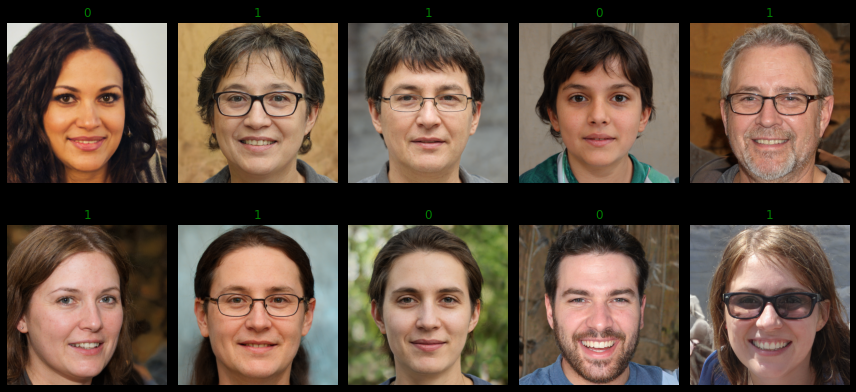

In [55]:
rand_id = random.randint(0, 240)
display_image_grid(val_images_filepaths[rand_id:rand_id + 10])

In [56]:
class GlassesDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label_id = get_id_from_path(image_filepath)
        label = float(target_vector[label_id - 1])

        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [57]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=230),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.Flip(),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.CoarseDropout(max_holes=5, min_holes=3, max_width=60, max_height=60, min_width=20, min_height=20),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_dataset = GlassesDataset(images_filepaths=train_images_filepaths, transform=train_transform) 

In [58]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=230),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = GlassesDataset(images_filepaths=val_images_filepaths, transform=val_transform)  

In [59]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

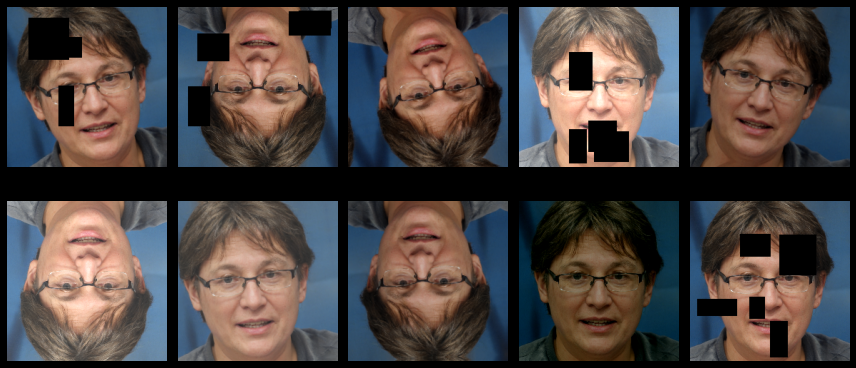

In [60]:
random.seed(41)
visualize_augmentations(train_dataset)

In [61]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [62]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [63]:
params = {
    "model": "mobilenet_v3_small",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": 1,
    "epochs": 10,
}

In [74]:
class BaselineModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

In [75]:
model = getattr(models, params["model"])(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=1, bias=True),
)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [76]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True,
)

In [77]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [83]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    outp_log = []
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):

            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            outp_log.append(f'{output}')
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return outp_log

In [84]:
# unfreeze_top = 4
# total_length = len(list(model.parameters()))
# for i, param in enumerate(model.parameters()):
#     if i >=  total_length - unfreeze_top:
#         break
#     param.requires_grad = False

In [85]:
outp_log = []
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    outp_log += validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.283 | Accuracy: 0.886: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]
Epoch: 1. Validation. Loss: 0.412 | Accuracy: 0.833: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it]
Epoch: 2. Train.      Loss: 0.273 | Accuracy: 0.892: 100%|██████████| 125/125 [04:34<00:00,  2.20s/it]
Epoch: 2. Validation. Loss: 0.509 | Accuracy: 0.775: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]
Epoch: 3. Train.      Loss: 0.261 | Accuracy: 0.897: 100%|██████████| 125/125 [04:29<00:00,  2.16s/it]
Epoch: 3. Validation. Loss: 0.444 | Accuracy: 0.885: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]
Epoch: 4. Train.      Loss: 0.253 | Accuracy: 0.900: 100%|██████████| 125/125 [04:26<00:00,  2.13s/it]
Epoch: 4. Validation. Loss: 0.326 | Accuracy: 0.862: 100%|██████████| 8/8 [00:16<00:00,  2.00s/it]
Epoch: 5. Train.      Loss: 0.249 | Accuracy: 0.902: 100%|██████████| 125/125 [04:06<00:00,  1.97s/it]
Epoch: 5. Validation. Loss: 0.428 | Accuracy: 0.870: 100%|██████████| 8/8 [00:14<00:00,  

In [86]:
torch.save(model.state_dict(), 'trained_model/trasfer_weights.pt')

In [87]:
class GlassesInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=230),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = GlassesInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True,
)

In [88]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        predicted_labels += [1 if has_glasses else 0 for has_glasses in predictions]

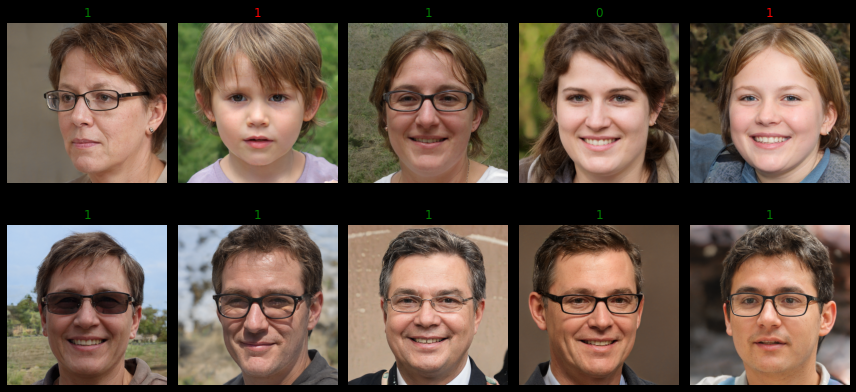

In [92]:
display_image_grid(test_images_filepaths[30:40], predicted_labels)